# Feature Extraction - eine Methode der "Dimensionality Reduction"

Nur Überschriften und Erklärungen im Notebook sind auf Deutsch, ``#comments`` und ``code`` sind auf Englisch. Dieses Mindestmaß an Englisch hat sich als gute Praxis erwiesen. Es ist ratsam sich das Coding in Englisch anzugewöhnen (oder beizubehalten), da Sie so auch den ``code`` ohne Weiteres an internationale Partner weitergeben können oder in Foren wie https://github.com gemeinsam Projekte bearbeiten können.

# Inhalt
* 1 Setup
* 2 PCA mit NumPy
* 3 PCA mit scikit-learn
* 4 Anhänge

# 1 | Setup

Hier werden wichtige Module ``modules`` geladen und es wird überprüft, dass die nötigen Mindestanforderungen für die Softwareaktualität gegeben sind.

* ``Python 3.5`` oder neuer
* es könnte evtl. mit ``Python 2.x`` laufen, aber davon wird abgeraten
* Scikit-Learn ≥0.20 (PCA https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Hier wird eine plotting routine definiert, da es in Python sehr umständlich ist schöne Vektoren zu plotten.

In [2]:
# CI color
lila = mpl.cm.get_cmap('plasma')

def plot_PCs(data, fig, ax, svd=None, pca=None):

        
    ax.plot(X[:, 0], X[:, 1], 'o', color=lila(0.8), label=r'Daten $\mu=0$')
    
    if svd is not None:
        PC1 = svd[:,0]
        PC2 = svd[:,1]
        
        # line 
        ax.plot([-10 * PC1[0], 10 * PC1[0]], [-10 * PC1[1], 10 * PC1[1]], 'k-', zorder=1)
        ax.plot([-10 * PC2[0], 10 * PC2[0]], [-10 * PC2[1], 10 * PC2[1]], 'k:', zorder=1)
        
        # principal components from SVD
        ax.arrow(0, 0, PC1[0], PC1[1], head_width=0.3, linewidth=2, length_includes_head=True, head_length=0.3, fc=lila(0.3), ec=lila(0.3))
        ax.arrow(0, 0, PC2[0], PC2[1], head_width=0.3, linewidth=2, length_includes_head=True, head_length=0.3, fc='w', ec=lila(0.3))
        plt.text(1.5,-1, 'NumPy SVD', color=lila(0.3))
    
    if pca is not None:
        # principal components from scikit-learn
        ax.arrow(0, 0, pca.components_[0,0], pca.components_[0,1], head_width=0.3, linewidth=2, length_includes_head=True, head_length=0.3, fc=lila(0.1), ec=lila(0.1))
        ax.arrow(0, 0, pca.components_[1,0], pca.components_[1,1], head_width=0.3, linewidth=2, length_includes_head=True, head_length=0.3, fc='w', ec=lila(0.1))
        plt.text(1.5,1, 'scikit-learn PCA', color=lila(0.1))
    
    
    # axis
    ax.plot([0], [0], 'ko')
    ax.arrow(-10, 0, 20, 0, head_width=0.5, linewidth=1, length_includes_head=True, 
             head_length=0.5, fc='k', ec='k', alpha=0.7)
    ax.arrow(0, -10, 0, 20, head_width=0.5, linewidth=1, length_includes_head=True, 
             head_length=0.5, fc='k', ec='k', alpha=0.7)
    
    
    
    ax.set_xlabel(r'X$_{m,1}-\mu_{m,1}$')
    ax.set_ylabel(r'X$_{m,2}-\mu_{m,2}$')

    
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    ax.grid(True, zorder=0)


    return ax

# 2 | PCA mit NumPy

Nun, da wir uns mit der Theorie vertraut gemacht haben, können wir beginnen. 
Zuerst führen wir die PCA mit NumPy durch. Diese Variante ist umständlicher, aber man sieht mehr, was hinter den Kulissen vorgeht.

Wir geben unsere Matrix als ``np.array`` ein. Hier sei Matrix $A=$``X``.

In [3]:
import numpy as np

X = np.array([[3, 7], [-4, -6], [7, 8], [1, -1], [-4, -1], [-3, -7]])
X

array([[ 3,  7],
       [-4, -6],
       [ 7,  8],
       [ 1, -1],
       [-4, -1],
       [-3, -7]])

Wir schauen uns kurz die Datenpunkte an.

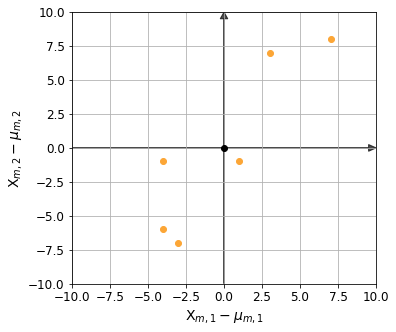

In [4]:
# using plotting command from above
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax = plot_PCs(data=X, fig=fig, ax=ax)#, svd=Vt.T[:, :2], pca=pca)

Wir sehen, dass die Daten bereits zentriert sind. Das erkennt man auch an der Matrix ``X`` (Spaltensummen = 0). Das überprüfen wir auch nochmal.

In [5]:
X.mean(axis=0)

array([0., 0.])

Wir führen die SVD mit NumPy durch. 

In [6]:
# for general use do not forget to center
X_centered = X - X.mean(axis=0)

# Singular Value Decomposition
U, s, Vt = np.linalg.svd(X_centered)

Ob die Faktorisierung auch funktioniert hat, wird hier getestet.

In [7]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

# test X == USV^T?
np.allclose(X_centered, U.dot(S).dot(Vt))

True

Eigentlich interessiert uns nur ``Vt``. Das ist die Matrix mit den Eigenvektoren von $A^TA$.

Wir erhalten unsere Matrix $W_{n\times 2}$ für $d=2$.

In [8]:
W_2comp = Vt.T[:, :2]

In [9]:
W_2comp

array([[-0.56062881,  0.82806723],
       [-0.82806723, -0.56062881]])

Die Principal Components können auch ausgegeben werden.

In [10]:
PC1 = Vt.T[:, 0]
PC2 = Vt.T[:, 1]

In [11]:
PC1

array([-0.56062881, -0.82806723])

In [12]:
PC2

array([ 0.82806723, -0.56062881])

Wir zeichnen nun die mit NumPy gefundenen PC1 und PC2 ein.

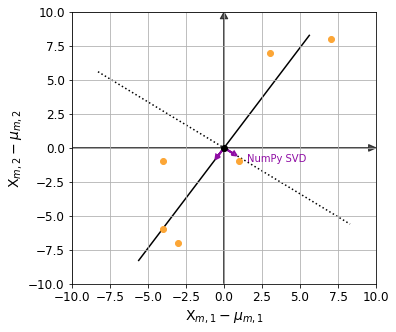

In [13]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax = plot_PCs(data=X, fig=fig, ax=ax, svd=Vt.T[:, :2])#, pca=pca)

Wir erhalten die Matrix $A_E(m\times d)$ indem wir das Matrixprodukt $A_{m\times n}W_{n\times d}$ ausführen.

In [14]:
X2D_using_svd = X_centered.dot(W_2comp)
X2D_using_svd.shape

(6, 2)

# 3 | scikit-learn PCA

Nun schauen wir uns PCA mit ``sklearn`` etwas genauer an. Die Matrix $A$ sei hier ``X``. Zentriert wird bei ``sklearn`` automatisch.

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2, svd_solver='full')#, random_state=42)
X2D_using_scikit = pca.fit_transform(X)

In [16]:
# A_E from scikit-learn
X2D_using_scikit

array([[ 7.47835704,  1.44019997],
       [-7.21091862, -0.05150393],
       [10.54893951, -1.31144014],
       [-0.26743842, -1.38869604],
       [-3.07058247,  2.75164011],
       [-7.47835704, -1.44019997]])

Nun der Vergleich mit dem Ergebnis von NumPy (siehe Abschnitt 2):

In [17]:
# A_E from NumPy
X2D_using_svd

array([[ -7.47835704,  -1.44019997],
       [  7.21091862,   0.05150393],
       [-10.54893951,   1.31144014],
       [  0.26743842,   1.38869604],
       [  3.07058247,  -2.75164011],
       [  7.47835704,   1.44019997]])

Die Zahlenwerte sind gleich, aber die Vorzeichen sind anders. Wie kommt das?

Schauen wir uns dazu nochmal die PC1 und PC2 an:

In [18]:
# PC1, PC2 with sklearn
pca.components_

array([[ 0.56062881,  0.82806723],
       [-0.82806723,  0.56062881]])

In [20]:
# PC1, PC2 with NumPy
Vt.T

array([[-0.56062881,  0.82806723],
       [-0.82806723, -0.56062881]])

Es Vektoren gleicher Basis, allerdings mit negativen Vorfaktoren.

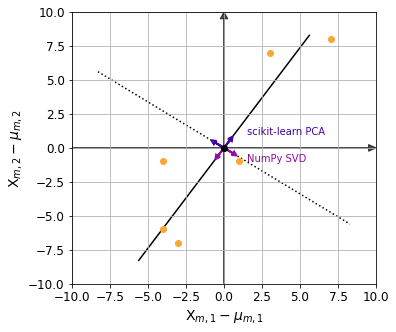

In [21]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax = plot_PCs(data=X, fig=fig, ax=ax, svd=Vt.T[:, :2], pca=pca)

Mit ``sklearn`` kann man sich praktischerweise auch die Varianzen ausgeben lassen. Fast 95% liegen bei diesem Beispiel in PC1.

In [22]:
pca.explained_variance_ratio_

array([0.94876373, 0.05123627])

Nun zurück zum den Folien.

# 4 | Anhänge

Hier finden Sie andere Darstellungen des gleichen Problems.

Saving figure BV_SVD_PCA


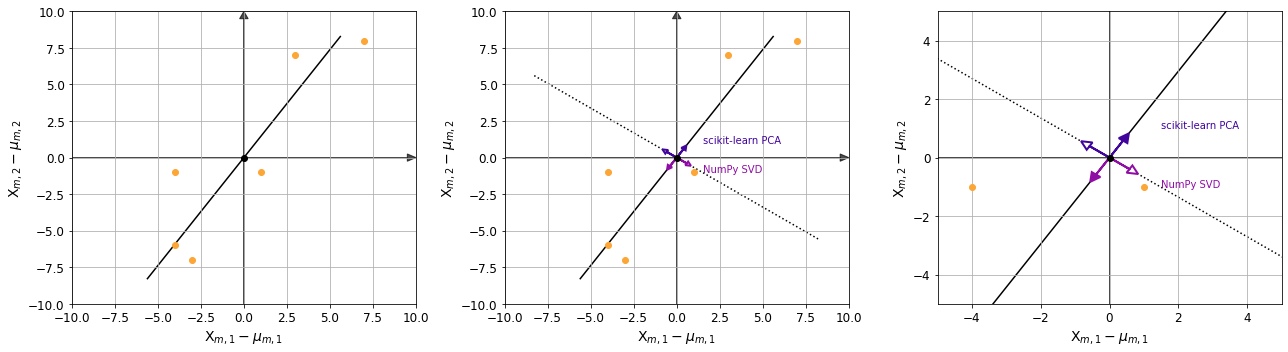

In [23]:
# figure setup
fig = plt.figure(figsize=(18,5))

# subplot 1 (only data and PC1)
ax = fig.add_subplot(131)
ax = plot_PCs(data=X, fig=fig, ax=ax)#, svd=Vt.T[:, :2], pca=pca)
ax.plot([-10 * PC1[0], 10 * PC1[0]], [-10 * PC1[1], 10 * PC1[1]], 'k-', zorder=1)

# subplot 2 (data, PC1, PC2)
ax2 = fig.add_subplot(132)
ax2 = plot_PCs(data=X, fig=fig, ax=ax2, svd=Vt.T[:, :2], pca=pca)

# subplot 3 (zoomin of subplot 2)
ax3 = fig.add_subplot(133)
ax3 = plot_PCs(data=X, fig=fig, ax=ax3, svd=Vt.T[:, :2], pca=pca)
ax3.set_xlim(-5, 5)
ax3.set_ylim(-5, 5)
save_fig('BV_SVD_PCA')

(-10.0, 10.0)

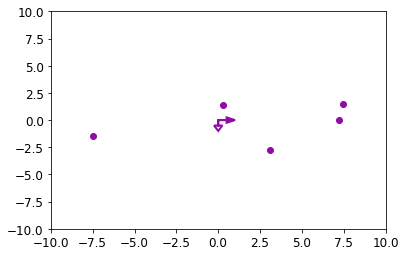

In [24]:
# Plot of the feature-extracted dataset A_E = A W
plt.plot(X2D_using_svd[:,0], X2D_using_svd[:,1], 'o', color=lila(0.3))
plt.arrow(0, 0, 1, 0, head_width=0.5, linewidth=2, length_includes_head=True, head_length=0.5, fc=lila(0.3), ec=lila(0.3))
plt.arrow(0, 0, 0, -1, head_width=0.5, linewidth=2, length_includes_head=True, head_length=0.5, fc='w', ec=lila(0.3))
plt.xlim(-10, 10)
plt.ylim(-10, 10)